In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import re

# Set plot style for better visualization
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
# Load the Reddit dataset from the raw data directory
data_path = '../data/raw/reddit.csv'
df = pd.read_csv(data_path)

In [17]:
# Display basic information and first few rows
print("Dataset Info:")
df.info()
print("\nFirst 5 Rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clean_comment    37149 non-null  object
 1   category         37249 non-null  int64 
 2   sentiment_label  37249 non-null  object
 3   word_count       37249 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB

First 5 Rows:


,clean_comment,category,sentiment_label,word_count
0,family mormon have never tried explain them t...,1,Positive,39
1,buddhism has very much lot compatible with chr...,1,Positive,196
2,seriously don say thing first all they won get...,-1,Negative,86
3,what you have learned yours and only yours wha...,0,Neutral,29
4,for your own benefit you may want read living ...,1,Positive,112


Missing Values:
clean_comment      100
category             0
sentiment_label      0
word_count           0
dtype: int64


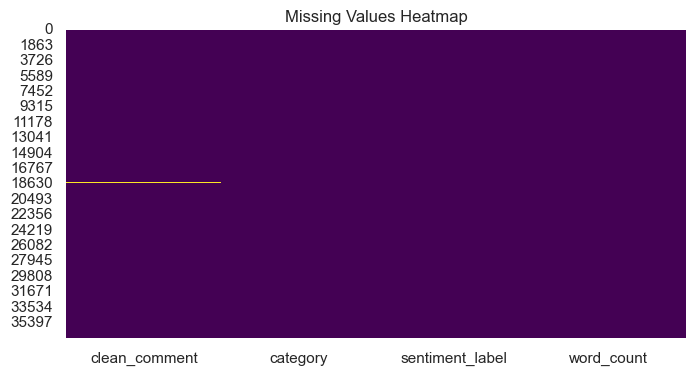

In [8]:
# Calculate and display missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

# Visualize missing values
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

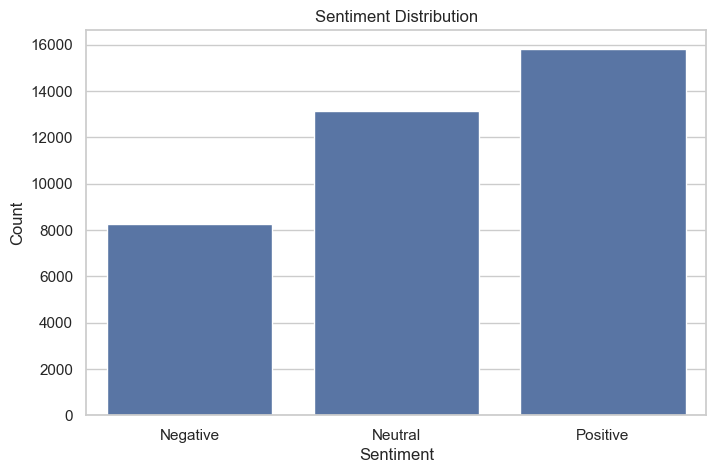

Sentiment Distribution (%):
sentiment_label
Positive    42.50
Neutral     35.28
Negative    22.22
Name: proportion, dtype: float64


In [11]:
# Map category values to labels for clarity
sentiment_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
df['sentiment_label'] = df['category'].map(sentiment_map)

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=df, order=['Negative', 'Neutral', 'Positive'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Display percentage distribution
print("Sentiment Distribution (%):")
print((df['sentiment_label'].value_counts(normalize=True) * 100).round(2))

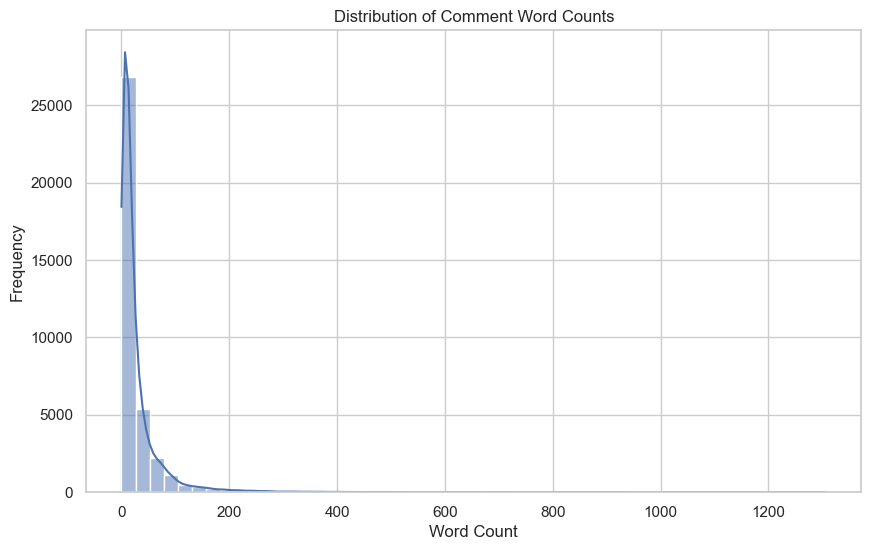

Word Count Statistics:
count    37249.000000
mean        29.324895
std         56.531457
min          0.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64


In [5]:
# Calculate comment lengths (word count)
df['word_count'] = df['clean_comment'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Comment Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Summary statistics for word counts
print("Word Count Statistics:")
print(df['word_count'].describe())

In [12]:
df.sample(5)

,clean_comment,category,sentiment_label,word_count
17059,how can you get quickfang again without doing ...,1,Positive,19
22725,yoonjo hello venus uni lime hello venus,0,Neutral,7
32771,seems randia have pretty low bar for entertai...,1,Positive,35
13113,modi wali script kaam bhi rahi hai kuch asar r...,0,Neutral,10
31773,honest hahaha,1,Positive,2


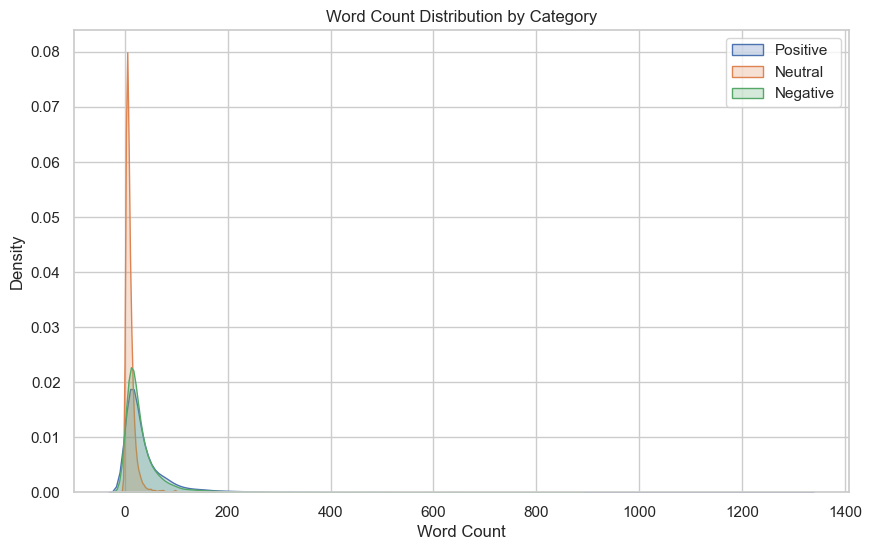

In [ ]:
# Plot word count distribution by category
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['category'] == 1]['word_count'], label='Positive', fill=True)
sns.kdeplot(df[df['category'] == 0]['word_count'], label='Neutral', fill=True)
sns.kdeplot(df[df['category'] == -1]['word_count'], label='Negative', fill=True)
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()

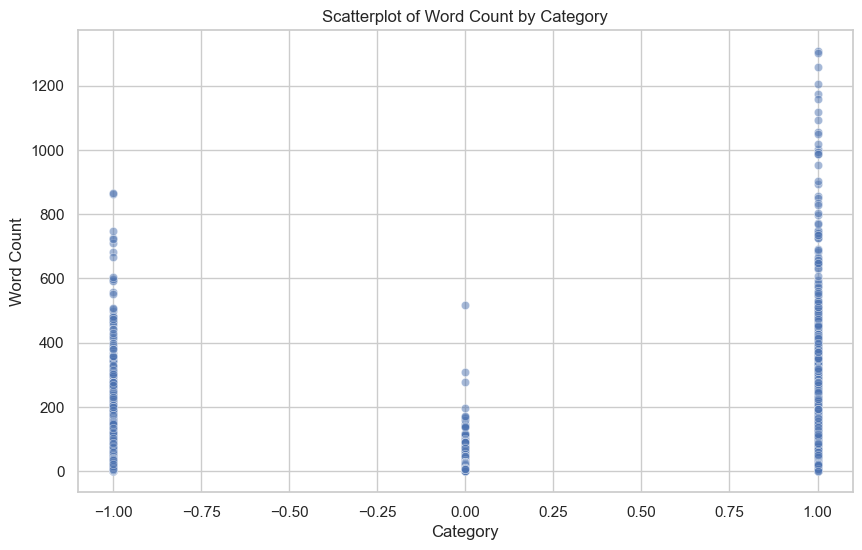

In [19]:
# Scatterplot between 'category' and 'wordcount'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='category', y='word_count', alpha=0.5)
plt.title('Scatterplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

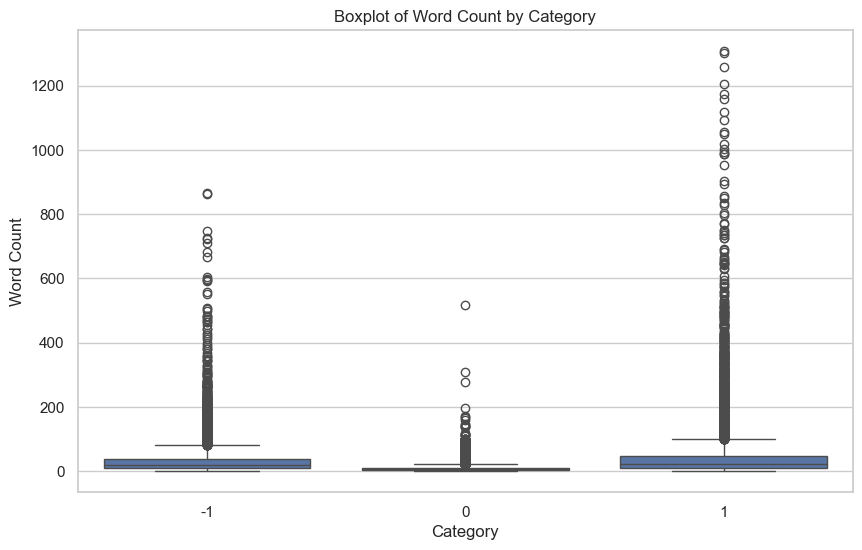

In [14]:
# Boxplot of word counts by category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

In [ ]:
# The median length of each comment
median_word_counts = df.groupby('category')['word_count'].median()
print(median_word_counts)

category
-1    19.0
 0     6.0
 1    21.0
Name: word_count, dtype: float64


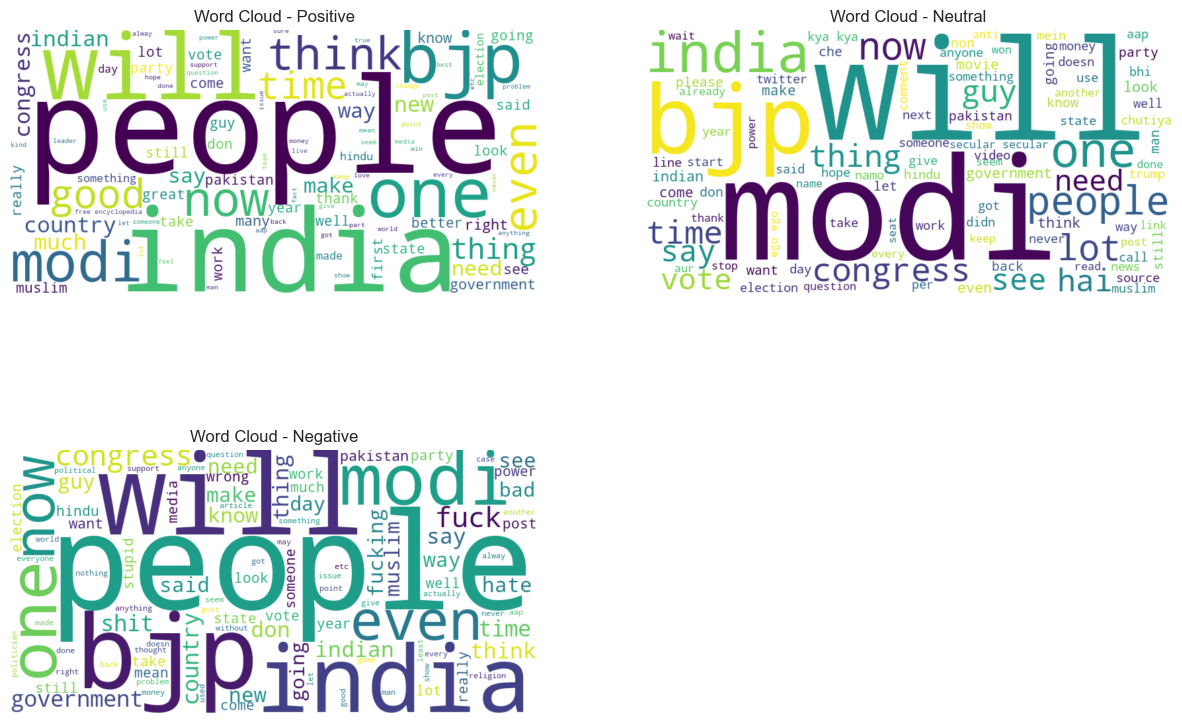

In [6]:
# Function to clean text for word cloud
def clean_text(text):
    if pd.isnull(text):
        return ''
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    return text

# Generate word clouds for each sentiment
sentiments = ['Positive', 'Neutral', 'Negative']
plt.figure(figsize=(15, 10))
for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(2, 2, i)
    text = ' '.join(df[df['sentiment_label'] == sentiment]['clean_comment'].apply(clean_text))
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {sentiment}')
    plt.axis('off')
plt.show()

In [7]:
# Function to get top N words
def get_top_words(text_series, n=10):
    words = ' '.join(text_series.apply(clean_text)).split()
    word_counts = Counter(words)
    return pd.DataFrame(word_counts.most_common(n), columns=['Word', 'Count'])

# Display top 10 words for each sentiment
for sentiment in sentiments:
    print(f"\nTop 10 Words for {sentiment}:")
    print(get_top_words(df[df['sentiment_label'] == sentiment]['clean_comment']))


Top 10 Words for Positive:
   Word  Count
0   the  37476
1   and  19210
2  that  10002
3   for   8329
4  this   8043
5   you   7162
6   are   6497
7  have   5472
8  they   5382
9   not   5313

Top 10 Words for Neutral:
   Word  Count
0   the   5731
1   and   2016
2  this   1624
3   you   1578
4   for   1350
5  that   1311
6   are   1091
7  same   1031
8   not    865
9  what    854

Top 10 Words for Negative:
   Word  Count
0   the  14553
1   and   7738
2  that   4151
3  this   3832
4   for   3314
5   you   3066
6   are   2981
7  they   2562
8   not   2526
9  have   2202


### Key Insights:
1. **Dataset Size**: The dataset has 37,249 entries with 'clean_comment' (text) and 'category' (sentiment: -1, 0, 1).
2. **Missing Values**: There are 100 missing comments, which need handling (e.g., imputation or removal).
3. **Sentiment Distribution**: The dataset may show class imbalance (check plot); consider oversampling/weighting for modeling.
4. **Text Characteristics**: Word counts vary (check histogram); long comments may need truncation for efficient modeling.
5. **Common Words**: Word clouds and top words highlight frequent terms; consider stop-word removal for better feature extraction.

### Next Steps:
- Preprocess data: Handle missing values, normalize text, remove stop words.
- Feature engineering: Create TF-IDF or embeddings for modeling.
- Plan YouTube data integration: Test API/scraping for comment collection.
- Save processed data to 'data/processed' and version with DVC.